In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
comex_df=pd.read_csv('/home/andre301267/git/BD/temp/imp_fert_ncm_quanti.csv').sort_values(by=['CO_ANO','CO_MES'])

In [2]:
comex_df.nick.unique()

array(['MOP', 'MOP<60', 'NK', 'NPK', 'Nit.Sódio Potássico 15 15',
       'Outros N', 'Outros nitratos de sódio', 'SAM', 'SOP<52', 'MAP',
       'NAM', 'Nit.Sódio natural<16,3', 'Outros Nit.Sódio potássico',
       'Outros potássicos', 'Superfosfatos<22', 'UREIA',
       'DAP arsênio> 6 mg/kg', 'NCa', 'Outros SOP', 'PK',
       'Superfosfato>45', 'Ureia, mesmo aquosa',
       'Outros Nit.Sódio, naturais', 'NP', 'Nitratos e fosfatos',
       'Superfosfatos>35', 'Outros superfosfatos'], dtype=object)

In [3]:
uf='BA'
nick='NK'
comex_df=comex_df[(comex_df.UF==uf)&(comex_df.nick==nick)]\
.drop(columns=['UF','nick','CO_NCM','CO_PAIS','CO_URF','VL_SEGURO_orig','VL_FRETE_orig',\
               'VL_FOB_orig','VL_FRETE','VL_SEGURO'])

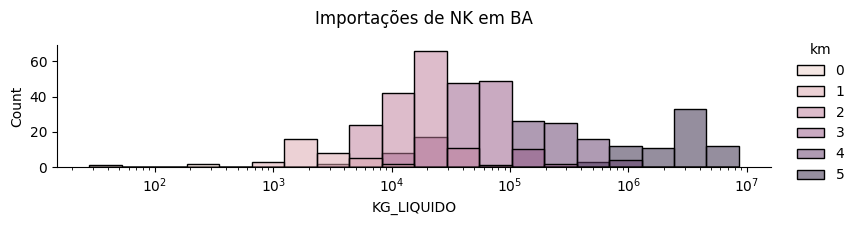

In [4]:
sns.displot(data=comex_df,x='KG_LIQUIDO',hue='km', log_scale=True,height=2,aspect=4).fig.suptitle(f"Importações de {nick} em {uf}",y=1.1)
plt.show()

In [5]:
10**5.4

251188.6431509582

In [6]:
10**6.25

1778279.410038923

In [7]:
km=int(input('Escolha o cluster (km) desejado:'))

Escolha o cluster (km) desejado: 5


In [8]:
comex_df=comex_df[comex_df.km==km]
comex_df.drop(columns='km',inplace=True)

In [9]:
comex_df=comex_df.groupby(by=['CO_ANO','CO_MES'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()\
.astype(int)

In [10]:
%run '/home/andre301267/git/BD/Comexstat/function/matriz_esparsa.ipynb'
comex_df_sp=matriz_esparsa(comex_df)

** Função matriz_esparsa(comex_df, ct) disponível **


In [11]:
%run '/home/andre301267/git/BD/Comexstat/function/escalona_tempo.ipynb'
comex_df_sc=escalona_tempo(comex_df_sp)

# Identifica a mês corrente
mês_corrente=comex_df_sc[comex_df_sc.CO_ANO==comex_df_sc.CO_ANO.max()].CO_MES.max()
# Completa escalonamento criano ano índice
comex_df_sc['ano_i']=comex_df_sc.CO_ANO.shift(mês_corrente)

** Função escalona_tempo(comex_df) disponível **


In [12]:
# Corrige na
k=comex_df_sc[comex_df_sc.ano_i.isna()]
w=comex_df_sc[~comex_df_sc.ano_i.isna()]
k=k.drop(columns='ano_i')
z=np.array(w[w.index.isin(k.index+8)].ano_i-1)
k['ano_i']=z
comex_df_sc=pd.concat([k,w])

In [13]:
# Corrige tipo
comex_df_sc[comex_df_sc.select_dtypes('float').columns]=comex_df_sc[comex_df_sc.select_dtypes('float').columns].astype(int)

In [14]:
# Identifica escalas
escalas=comex_df_sc.columns[-6:]
escalas

Index(['mes_i', 'bim_i', 'trim_i', 'quadri_i', 'sem_i', 'ano_i'], dtype='object')

In [15]:
list(enumerate(escalas))

[(0, 'mes_i'),
 (1, 'bim_i'),
 (2, 'trim_i'),
 (3, 'quadri_i'),
 (4, 'sem_i'),
 (5, 'ano_i')]

In [16]:
si=0

In [17]:
sc=escalas[si]

comex_df_sc_g=comex_df_sc.groupby(by=['ano_i',sc])[['KG_LIQUIDO','VL_FOB']].sum().reset_index().astype(int)

tab=comex_df_sc[['date','ano_i',sc]]
tab=tab.drop_duplicates(subset=['ano_i',sc])
tab=tab[tab.ano_i!=tab.ano_i.min()]

comex_df_sc_g=tab.merge(comex_df_sc_g)

g_a_sc_dict={'mes_i':12, 'bim_i':6, 'trim_i':4, 'quadri_i':3, 'sem_i':2}

g_i_sc_dict={'mes_i':1, 'bim_i':2, 'trim_i':3, 'quadri_i':4, 'sem_i':6}

l=len(comex_df_sc_g.columns)

In [18]:
g_a_sc_dict[sc]

12

In [19]:
comex_df_sc_g\
.insert(l,'mm_fob_'+sc,comex_df_sc_g.VL_FOB.rolling(g_a_sc_dict[sc]).sum())

In [20]:
comex_df_sc_g\
.insert(l,'mm_kg_'+sc,comex_df_sc_g.KG_LIQUIDO.rolling(g_a_sc_dict[sc]).sum())

comex_df_mm=comex_df_sc_g

comex_df_mm=comex_df_mm.dropna()

In [21]:
comex_df_mm=comex_df_mm.assign(fob_kg=comex_df_mm.VL_FOB/comex_df_mm.KG_LIQUIDO)

In [22]:
fob_kg_prev=comex_df_mm.fob_kg.tail(1).values[0]

In [23]:
comex_df_mm.fob_kg=comex_df_mm.fob_kg.shift(1)

In [24]:
comex_df_mm.head(1)

,date,ano_i,mes_i,KG_LIQUIDO,VL_FOB,mm_kg_mes_i,mm_fob_mes_i,fob_kg
11,2005-10-01,2005,2,0,0,1344000.0,574672.0,NaN


In [25]:
X_train=comex_df_mm[['date','fob_kg']]

In [26]:
X_train.date=X_train.date.astype(int)

In [27]:
y_train=comex_df_mm[['mm_kg_'+sc,'mm_fob_'+sc]]

In [28]:
from datetime import timedelta
date_prev=comex_df_mm.date.iloc[-g_a_sc_dict[sc]] + timedelta(days=365+1)

In [29]:
X_prev=pd.DataFrame({
    'date':[date_prev],
    'fob_kg':[fob_kg_prev]})

X_prev.date=X_prev.date.astype(int)

In [30]:
#from sklearn.linear_model import LinearRegression as REG
from sklearn.ensemble import RandomForestRegressor as REG
REG=REG()
REG.fit(X_train,y_train)
X_prev[['mm_kg_'+sc,'mm_fob_'+sc]]=REG.predict(X_prev)

In [31]:
X_prev=X_prev\
.assign(tipo=['prev'])\
.assign(ano_i=[comex_df.CO_ANO.max()])\
.assign(KG_LIQUIDO=X_prev['mm_kg_'+sc]-comex_df_mm['mm_kg_'+sc].iloc[-1]+comex_df_mm.iloc[-g_a_sc_dict[sc],3])\
.assign(VL_FOB=    X_prev['mm_fob_'+sc]-comex_df_mm['mm_fob_'+sc].iloc[-1]+comex_df_mm.iloc[-g_a_sc_dict[sc],4])
X_prev.insert(0,str(sc),1)

In [32]:
comex_df_mm=pd.concat([comex_df_mm.assign(tipo='real'),X_prev])

In [33]:
comex_df_mm.date=pd.to_datetime(comex_df_mm.date)

In [34]:
comex_df_mm=comex_df_mm[comex_df_mm.date.dt.year>2019]

In [35]:
comex_df_mm['fob_kg'].iloc[-1]=comex_df_mm['VL_FOB'].iloc[-1]/comex_df_mm['KG_LIQUIDO'].iloc[-1]

In [36]:
comex_df_mm.tail(15)

,date,ano_i,mes_i,KG_LIQUIDO,VL_FOB,mm_kg_mes_i,mm_fob_mes_i,fob_kg,tipo
224,2023-07-01,2022,11,3001600.0,2851295.00,18706900.0,15907591.00,NaN,real
225,2023-08-01,2022,12,0.0,0.00,18706900.0,15907591.00,0.949925,real
226,2023-09-01,2023,1,0.0,0.00,14204600.0,9715795.00,NaN,real
227,2023-10-01,2023,2,1416000.0,1208589.00,15620600.0,10924384.00,NaN,real
228,2023-11-01,2023,3,1532000.0,1345399.00,17152600.0,12269783.00,0.853523,real
229,2023-12-01,2023,4,0.0,0.00,17152600.0,12269783.00,0.878198,real
230,2024-01-01,2023,5,2876400.0,2509696.00,12329000.0,11784671.00,NaN,real
231,2024-02-01,2023,6,0.0,0.00,12329000.0,11784671.00,0.872513,real
232,2024-03-01,2023,7,1100000.0,958867.00,9926000.0,8873846.00,NaN,real
233,2024-04-01,2023,8,5916400.0,4983191.00,15842400.0,13857037.00,0.871697,real


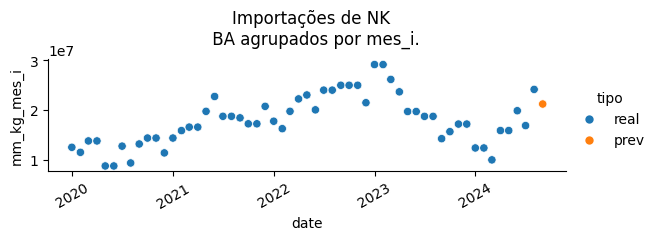

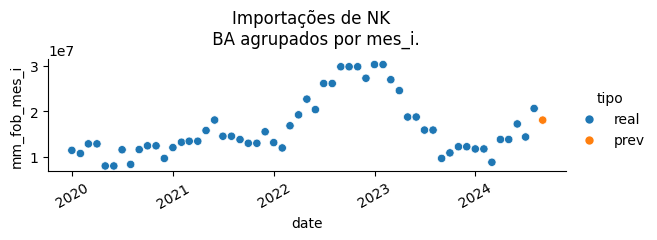

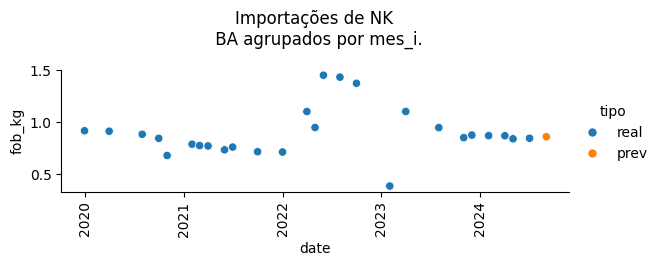

In [37]:
for cc in ['mm_kg_','mm_fob_','fob_kg']:
    kt='tipo'
    sct=sc
    if cc == 'fob_kg':
        sns.relplot(data=comex_df_mm[comex_df_mm[cc]<3],x='date',y=cc,height=2,aspect=3,hue='tipo')\
        .fig.suptitle(f"Importações de {nick} \n {uf} agrupados por {sc}.", y=1.2)
        plt.xticks(rotation=90)
        plt.show()
    else:
        sns.relplot(data=comex_df_mm,x='date',y=cc+str(sct),height=2,aspect=3, hue=kt)\
        .fig.suptitle(f"Importações de {nick} \n {uf} agrupados por {sc}.", y=1.1)
        plt.xticks(rotation=30)
        plt.show()